**Question 4 [Programming]: Bike Sharing Demand**

Q1) Forecast use of a city bikeshare system
You are provided hourly rental data spanning two years (Data (training and test) available here). The training set is
comprised of the first 19 days of each month, while the test set is the 20th to the end of the month. You must predict
the total count of bikes rented during each hour covered by the test set, using only information available prior to the
rental period. Fit a Poisson regression model to the count data (output). Treat year, month, weekday, hour, holiday,
weather, atemp, humidity, windspeed etc. as input features that are combined linearly to determine the rate
parameter of the Poisson distribution. Create a 80-20 split of the train data into training, and validation.

1) Explain maximum likelihood estimation in poisson regression and derive the loss function which is
used to estimate the parameters.

2) Find statistics of the dataset like mean count per year, month etc.

3) Plot count against any 5 features.

4) Apply L1 and L2 norm regularization over weight vectors, and find the best hyper-parameter
settings for the mentioned problem using validation data and report the accuracy on test data for
no regularization, L1 norm regularization and L2 norm regularization.

5) Determine most important features determining count of bikes rented.

Bike sharing systems are a means of renting bicycles where the process of obtaining membership, rental, and bike return is automated via a network of kiosk locations throughout a city. Using these systems, people are able rent a bike from a one location and return it to a different place on an as-needed basis. Currently, there are over 500 bike-sharing programs around the world.

The data generated by these systems makes them attractive for researchers because the duration of travel, departure location, arrival location, and time elapsed is explicitly recorded. Bike sharing systems therefore function as a sensor network, which can be used for studying mobility in a city. In this competition, participants are asked to combine historical usage patterns with weather data in order to forecast bike rental demand in the Capital Bikeshare program in Washington, D.C.
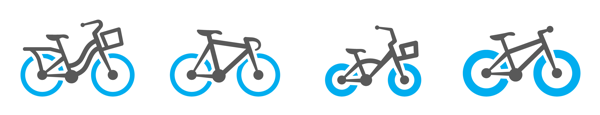


# 1) Explain maximum likelihood estimation in poisson regression and derive the loss function which is used to estimate the parameters.


The Poisson distribution describes such situations where the study variable is a count variable that represents the count of some relatively rare event. eg, the study variable can be the number of defects in the car engine of a reputed car maker.

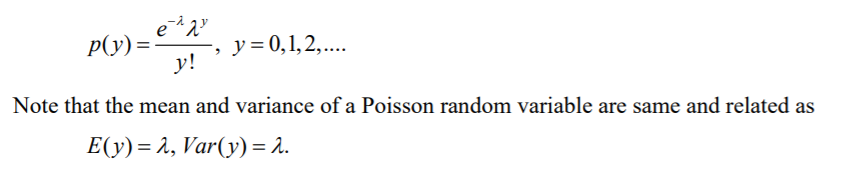


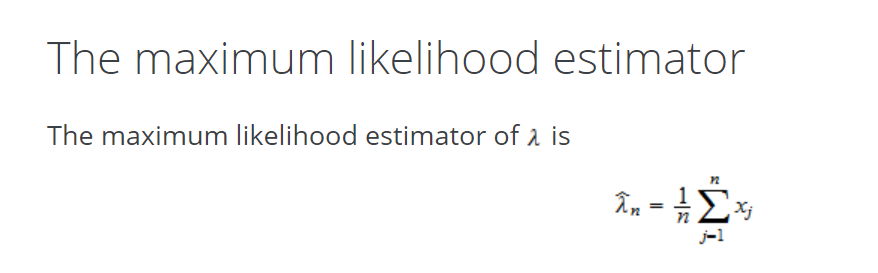



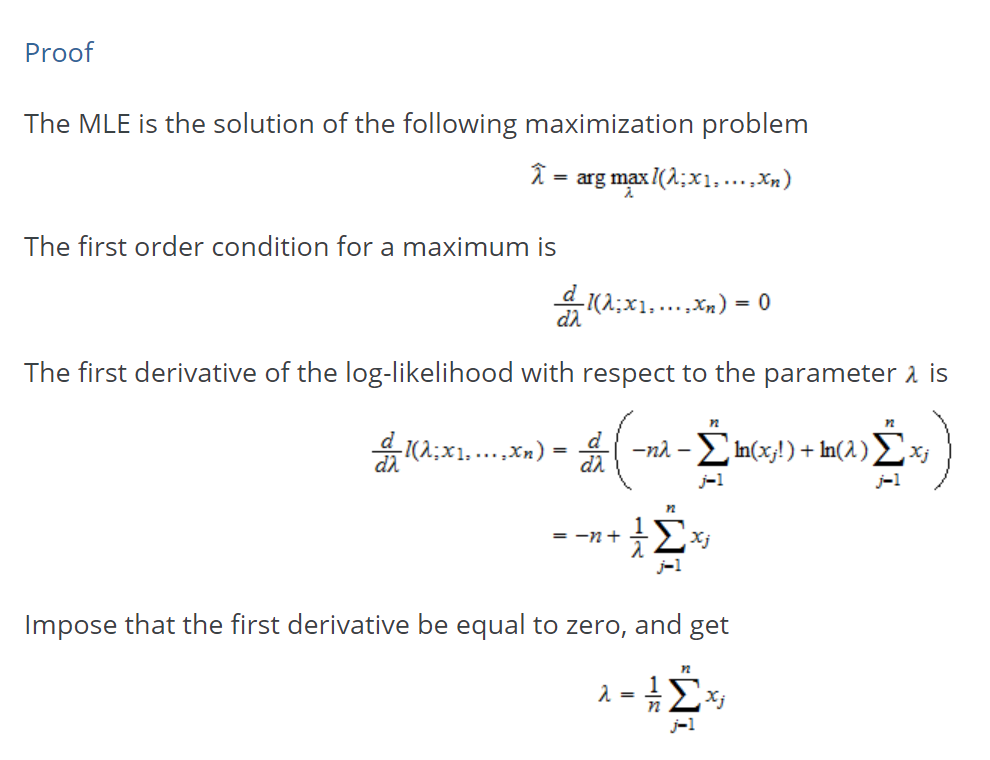

Src : https://www.statlect.com/fundamentals-of-statistics/Poisson-distribution-maximum-likelihood


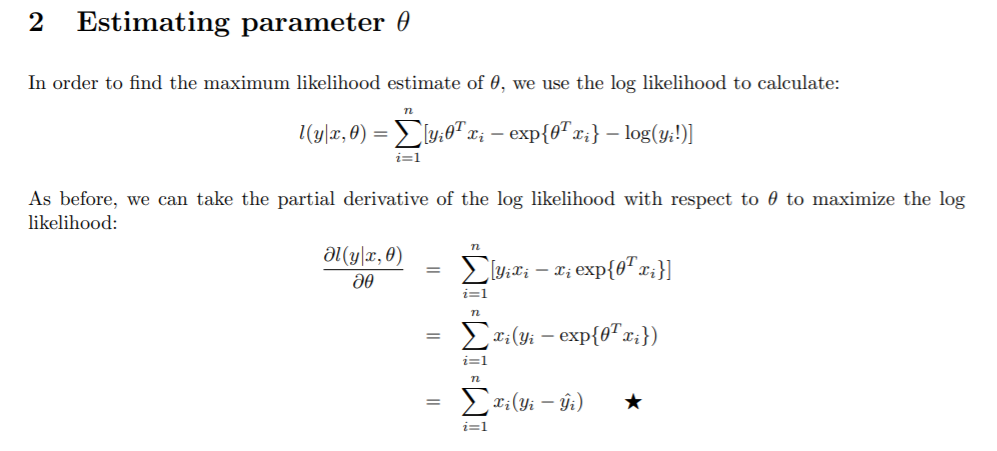

## Derivation:

https://www.cs.princeton.edu/~bee/courses/lec/lec_jan29.pdf


In [198]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


In [199]:
bike_df = pd.read_csv("data/train.csv")
bike_df_test = pd.read_csv("data/test.csv")
print(bike_df.shape)
print(bike_df_test.shape)
bike_df.head()

(10886, 12)
(6493, 9)


,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1


In [107]:
bike_df_test.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed
0,2011-01-20 00:00:00,1,0,1,1,10.66,11.365,56,26.0027
1,2011-01-20 01:00:00,1,0,1,1,10.66,13.635,56,0.0000
2,2011-01-20 02:00:00,1,0,1,1,10.66,13.635,56,0.0000
3,2011-01-20 03:00:00,1,0,1,1,10.66,12.880,56,11.0014
4,2011-01-20 04:00:00,1,0,1,1,10.66,12.880,56,11.0014


The training set is comprised of the first 19 days of each month

In [50]:
bike_df.datetime.unique()

array(['2011-01-01 00:00:00', '2011-01-01 01:00:00',
       '2011-01-01 02:00:00', ..., '2012-12-19 21:00:00',
       '2012-12-19 22:00:00', '2012-12-19 23:00:00'], dtype=object)

In [4]:
#checking if any rows are blank
print(bike_df.isnull().all(axis=1).sum())
#checking if columns have blank data
#lets check if any columns have blank data and what proportion
print(round(100*(bike_df.isnull().sum()/len(bike_df.index)), 2))

0
datetime      0.0
season        0.0
holiday       0.0
workingday    0.0
weather       0.0
temp          0.0
atemp         0.0
humidity      0.0
windspeed     0.0
casual        0.0
registered    0.0
count         0.0
dtype: float64


In [5]:
bike_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10886 entries, 0 to 10885
Data columns (total 12 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   datetime    10886 non-null  object 
 1   season      10886 non-null  int64  
 2   holiday     10886 non-null  int64  
 3   workingday  10886 non-null  int64  
 4   weather     10886 non-null  int64  
 5   temp        10886 non-null  float64
 6   atemp       10886 non-null  float64
 7   humidity    10886 non-null  int64  
 8   windspeed   10886 non-null  float64
 9   casual      10886 non-null  int64  
 10  registered  10886 non-null  int64  
 11  count       10886 non-null  int64  
dtypes: float64(3), int64(8), object(1)
memory usage: 1020.7+ KB


## Date time object has to be broken down below derived variables

In [200]:

bike_df["date"] = bike_df.datetime.apply(lambda x : x.split()[0])
bike_df["hour"] = bike_df.datetime.apply(lambda x : x.split()[1].split(":")[0]).astype("int")
bike_df["year"] = bike_df.datetime.apply(lambda x : x.split()[0].split("-")[0]).astype("int")
bike_df["month"] = bike_df.datetime.apply(lambda x : x.split()[0].split("-")[1]).astype("int")
bike_df["day"] = bike_df.datetime.apply(lambda x : x.split()[0].split("-")[2]).astype("int")

bike_df['dayofweek'] = pd.to_datetime(bike_df['datetime']).dt.dayofweek

## Dropping Datetime and Date variable along with casual and registered as they are just meta data about count

In [210]:
bike_df_cleaned1  = bike_df.drop(["date","datetime", "casual", "registered"],axis=1)

In [211]:
bike_df_cleaned1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10886 entries, 0 to 10885
Data columns (total 14 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   season      10886 non-null  int64  
 1   holiday     10886 non-null  int64  
 2   workingday  10886 non-null  int64  
 3   weather     10886 non-null  int64  
 4   temp        10886 non-null  float64
 5   atemp       10886 non-null  float64
 6   humidity    10886 non-null  int64  
 7   windspeed   10886 non-null  float64
 8   count       10886 non-null  int64  
 9   hour        10886 non-null  int32  
 10  year        10886 non-null  int32  
 11  month       10886 non-null  int32  
 12  day         10886 non-null  int32  
 13  dayofweek   10886 non-null  int64  
dtypes: float64(3), int32(4), int64(7)
memory usage: 1020.7 KB


## All Variables are either categorical or continous

# 2) Find statistics of the dataset like mean count per year, month etc.

In [9]:
bike_df_cleaned1.describe()

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count,hour,year,month,day,dayofweek
count,10886.000000,10886.000000,10886.000000,10886.000000,10886.00000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000
mean,2.506614,0.028569,0.680875,1.418427,20.23086,23.655084,61.886460,12.799395,36.021955,155.552177,191.574132,11.541613,2011.501929,6.521495,9.992559,3.013963
std,1.116174,0.166599,0.466159,0.633839,7.79159,8.474601,19.245033,8.164537,49.960477,151.039033,181.144454,6.915838,0.500019,3.444373,5.476608,2.004585
min,1.000000,0.000000,0.000000,1.000000,0.82000,0.760000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,2011.000000,1.000000,1.000000,0.000000
25%,2.000000,0.000000,0.000000,1.000000,13.94000,16.665000,47.000000,7.001500,4.000000,36.000000,42.000000,6.000000,2011.000000,4.000000,5.000000,1.000000
50%,3.000000,0.000000,1.000000,1.000000,20.50000,24.240000,62.000000,12.998000,17.000000,118.000000,145.000000,12.000000,2012.000000,7.000000,10.000000,3.000000
75%,4.000000,0.000000,1.000000,2.000000,26.24000,31.060000,77.000000,16.997900,49.000000,222.000000,284.000000,18.000000,2012.000000,10.000000,15.000000,5.000000
max,4.000000,1.000000,1.000000,4.000000,41.00000,45.455000,100.000000,56.996900,367.000000,886.000000,977.000000,23.000000,2012.000000,12.000000,19.000000,6.000000


## Univariate and Bivariate Analysis

### Analysing Target Variable "count"

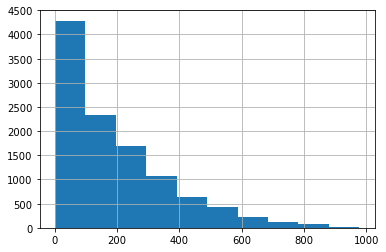

In [10]:
bike_df_cleaned1["count"].hist()

(10886, 16)


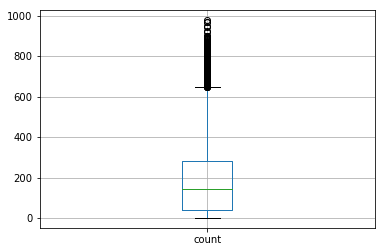

In [11]:
print(bike_df_cleaned1.shape)
bike_df_cleaned1.boxplot(column=['count'])

### Need outlier treatment

In [212]:
# Keeping till 97 quantile
q = bike_df_cleaned1["count"].quantile(0.97)
bike_df_cleaned2=bike_df_cleaned1[bike_df_cleaned1["count"] < q]

(10556, 14)


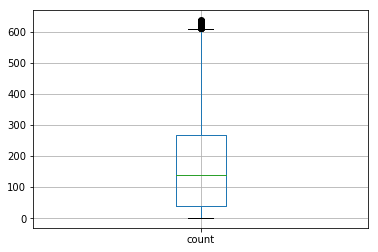

In [213]:
print(bike_df_cleaned2.shape)
bike_df_cleaned2.boxplot(column=['count'])

### Univariate Analysis

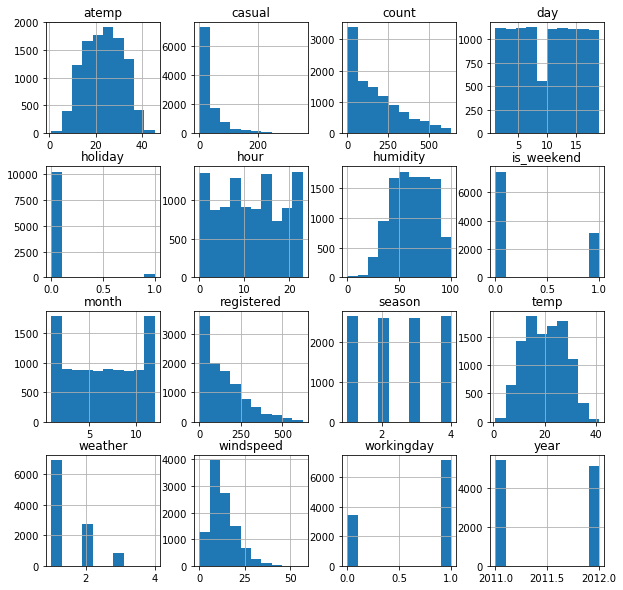

In [175]:

bike_df_cleaned2.hist()
plt.show()

## Bivariate Analysis
### Season
season - 1 = spring, 2 = summer, 3 = fall, 4 = winter

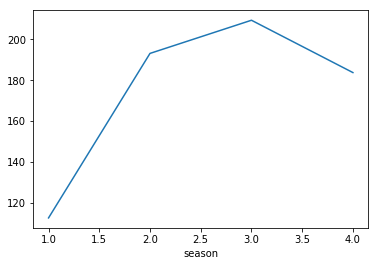

In [14]:
bike_df_cleaned2.groupby(['season']).mean()['count'].plot()

### Spring Season has low demand

## holiday - whether the day is considered a holiday - 0,1


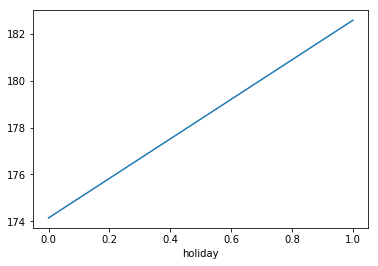

In [15]:
bike_df_cleaned2.groupby(['holiday']).mean()['count'].plot()

## workingday - whether the day is neither a weekend nor holiday

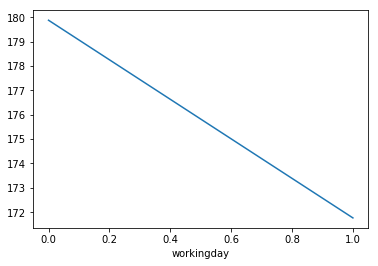

In [16]:
bike_df_cleaned2.groupby(['workingday']).mean()['count'].plot()

### weather 
1: Clear, Few clouds, Partly cloudy, Partly cloudy

2: Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist

3: Light Snow, Light Rain + Thunderstorm + Scattered clouds, Light Rain + Scattered clouds

4: Heavy Rain + Ice Pallets + Thunderstorm + Mist, Snow + Fog

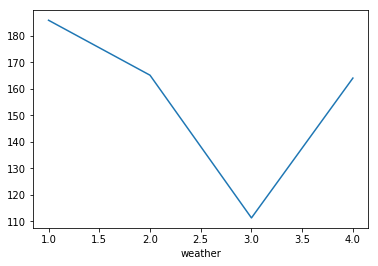

In [17]:
bike_df_cleaned2.groupby(['weather']).mean()['count'].plot()

## temp - temperature in Celsius


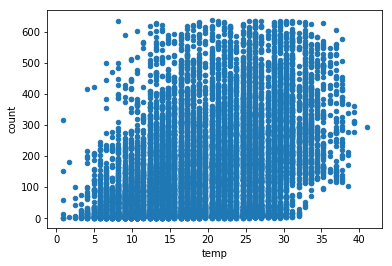

In [18]:
bike_df_cleaned2.plot.scatter(x='temp',y='count')

### atemp - "feels like" temperature in Celsius


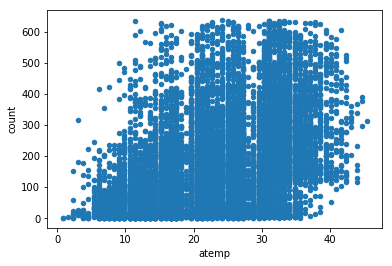

In [19]:
bike_df_cleaned2.plot.scatter(x='atemp',y='count')

## humidity - relative humidity


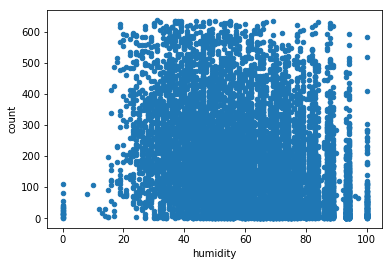

In [20]:
bike_df_cleaned2.plot.scatter(x='humidity',y='count')

## windspeed - wind speed


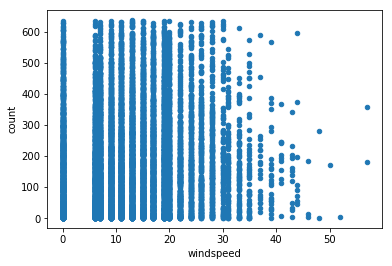

In [21]:
bike_df_cleaned2.plot.scatter(x='windspeed',y='count')

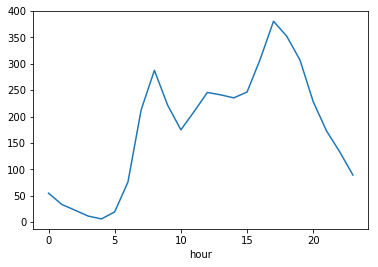

In [24]:
bike_df_cleaned2.groupby(['hour']).mean()['count'].plot()

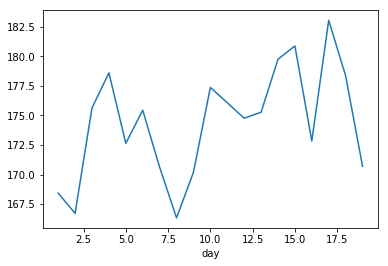

In [25]:
bike_df_cleaned2.groupby(['day']).mean()['count'].plot()

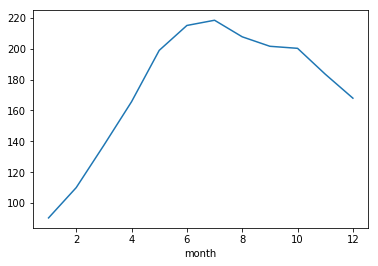

In [26]:
bike_df_cleaned2.groupby(['month']).mean()['count'].plot()

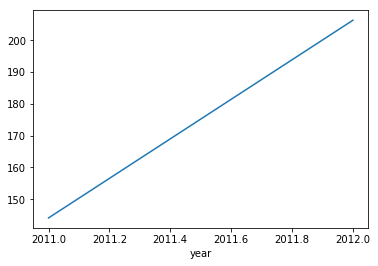

In [27]:

bike_df_cleaned2.groupby(['year']).mean()['count'].plot()

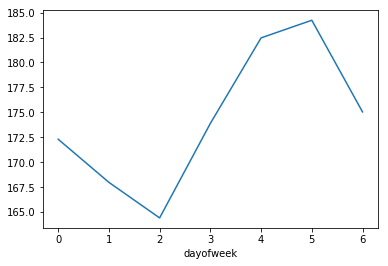

In [28]:
bike_df_cleaned2.groupby(['dayofweek']).mean()['count'].plot()

## Coorelation

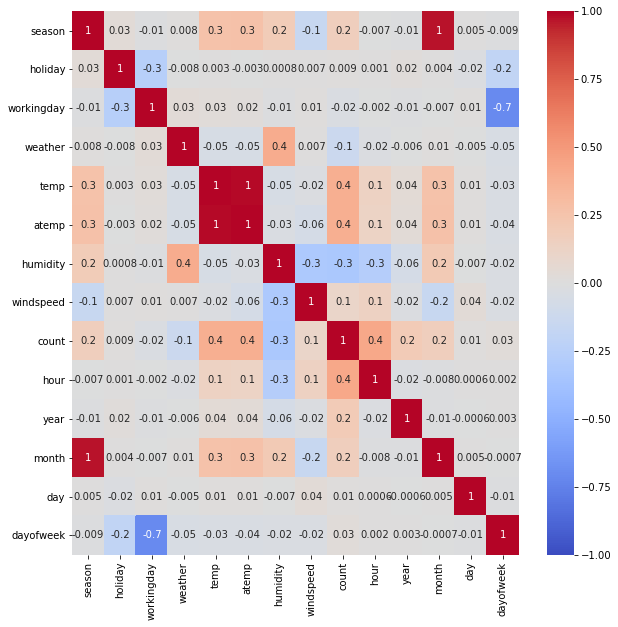

In [214]:
import seaborn as sns
fig, ax = plt.subplots(figsize=(10,10))  
sns.heatmap(bike_df_cleaned2.corr(),fmt='.1g', annot=True,  vmin=-1, vmax=1, center= 0, cmap= 'coolwarm', ax=ax)

### Working day is highly correlated with day of week. Dropping Day of Week
### Month is highly correlated with Season. Dropping Month
### atemp is highly correlated with temp. Dropping temp


In [225]:
bike_df_cleaned3  = bike_df_cleaned2.drop(["dayofweek","month", "temp"],axis=1)

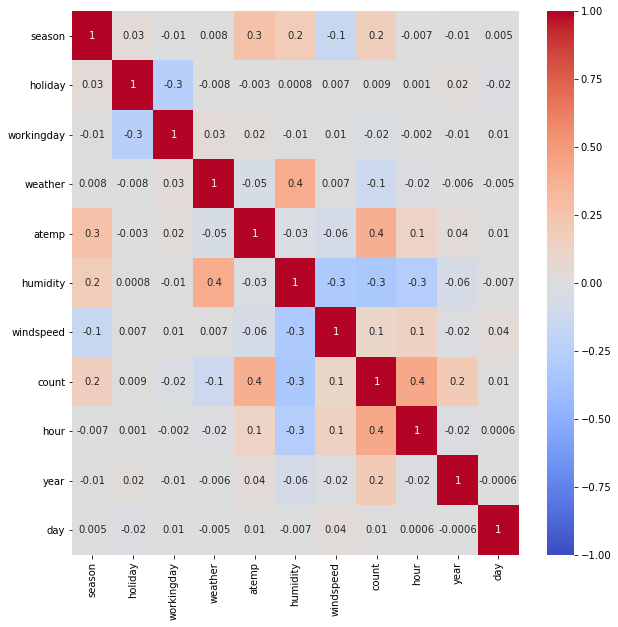

In [226]:
fig, ax = plt.subplots(figsize=(10,10))  
sns.heatmap(bike_df_cleaned3.corr(),fmt='.1g', annot=True,  vmin=-1, vmax=1, center= 0, cmap= 'coolwarm', ax=ax)

# Linear Regression Model

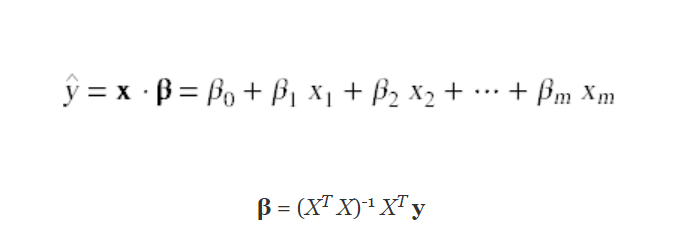

B0 - BIAS

B1,B2 .. Bm - the other Beta values are coefficients.

## Cost Function and Gradient Descent
### The cost function :
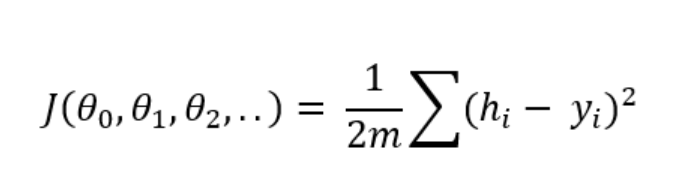

### The gradient descent
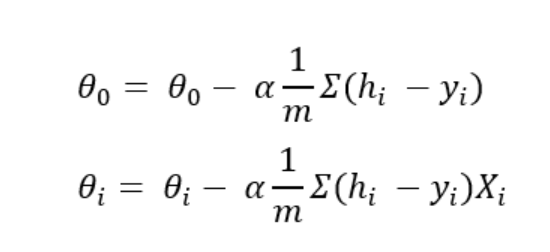

Alpha is learning Rate

In [505]:
# Add a column of ones for the bias term. I chose 1 because if you multiply one with any value, that value does not change
bike_df_cleaned4 = pd.concat([pd.Series(1, index=bike_df_cleaned3.index, name='BIAS'), bike_df_cleaned3], axis=1)
bike_df_cleaned4.head()

,BIAS,season,holiday,workingday,weather,atemp,humidity,windspeed,count,hour,year,day
0,1,1,0,0,1,14.395,81,0.0,16,0,2011,1
1,1,1,0,0,1,13.635,80,0.0,40,1,2011,1
2,1,1,0,0,1,13.635,80,0.0,32,2,2011,1
3,1,1,0,0,1,14.395,75,0.0,13,3,2011,1
4,1,1,0,0,1,14.395,75,0.0,1,4,2011,1


In [506]:

class LinearRegression:
    def __init__(self,X,Y): #initialize all parameters
        self.X=X
        self.Y=Y
        # Row
        self.m=X.shape[0]
        # Column
        self.n=X.shape[1]
        # Initiate the theta values with Random Values
        self.theta=np.random.randn(X.shape[1])
        
    def hypothesis(self):
        return self.X * self.theta

    def computeCostFunction(self):
        y1 = self.hypothesis()
        y1 = np.sum(y1, axis=1)
        self.J = sum(np.sqrt((y1-self.Y)**2))/(2*self.m)
        return self.J
    
    def computeCostFunctionLasso(self):
        # α * (sum of absolute value of coefficients)
        y1 = self.hypothesis()
        y1 = np.sum(y1, axis=1)
        self.J = sum(np.sqrt((y1-self.Y)**2))/(2*self.m)
        return self.J
    
    def computeCostFunctionRidge(self):
        y1 = self.hypothesis()
        y1 = np.sum(y1, axis=1)
        self.J = sum(np.sqrt((y1-self.Y)**2))/(2*self.m)
        return self.J
    
    # This function will take learning rate(alpha in the formula), and epochs(or num_of_iter) as input.
    # We need to keep updating the theta values until the cost function reaches its minimum.
    def performGradientDescent(self,num_of_iter,alpha):
        self.Cost_history=[]
        self.theta_history=[]
        for x in range(num_of_iter):
            h=np.dot(self.X,self.theta)
            J=self.computeCostFunction()
            self.Cost_history.append(J)
            self.theta_history.append(self.theta)
            temp=h-self.Y
            self.theta=self.theta-(alpha/self.m)*(self.X.T.dot(temp))
        return self.theta,self.Cost_history,self.theta_history
    
        
    def predict(self,X_test,Y_test):
        self.Y_pred=np.dot(X_test,self.theta)
#         self.Y_pred = [0 if i <=0 else self.Y_pred for i in self.Y_pred]
        return self.Y_pred
    
    def predictUsingNormalEquation(self,X_test,Y_test):
        inv=np.linalg.inv(np.dot(self.X.T,self.X))
        self.w=np.dot(np.dot(inv,self.X.T),self.Y)
        y_pred=np.dot(X_test,self.w)
#         self.Y_pred = [0 if i <=0 else self.Y_pred for i in self.Y_pred]
        return y_pred


In [507]:
# shuffle the DataFrame rows 
bike_df_cleaned4 = bike_df_cleaned4.sample(frac = 1) 

In [508]:
Y = bike_df_cleaned4.pop("count")
X = bike_df_cleaned4
print(Y.shape)
print(X.shape)

(10556,)
(10556, 11)


In [509]:
# Normalizing X
X = X/np.max(X)
X.head()

,BIAS,season,holiday,workingday,weather,atemp,humidity,windspeed,hour,year,day
6774,1.0,0.25,0.0,1.0,0.25,0.666703,0.61,0.298225,0.565217,1.000000,1.000000
407,1.0,0.25,0.0,1.0,0.50,0.299967,0.93,0.000000,1.000000,0.999503,0.947368
10717,1.0,1.00,0.0,1.0,0.50,0.299967,0.56,0.263195,1.000000,1.000000,0.631579
10479,1.0,1.00,0.0,1.0,0.25,0.450005,0.82,0.157870,0.043478,1.000000,0.157895
7511,1.0,0.50,0.0,0.0,0.25,0.549995,0.48,0.000000,0.347826,1.000000,0.631579


In [510]:
#Dividing Data in Train and Validation
train_size=int(0.8 * bike_df_cleaned4.shape[0])
test_size=int(0.2 * bike_df_cleaned4.shape[0])
print("Training size : "+ str(train_size))
print("Testing size : "+str(test_size))

#training set split
X_train=X.iloc[0:train_size,:]
Y_train=Y.iloc[0:train_size]
print("Train Shape")
print(X_train.shape)
print(Y_train.shape)


#testing set split
X_test=X.iloc[train_size:,:]
Y_test=Y.iloc[train_size:]
print("Test Shape")
print(X_test.shape)
print(Y_test.shape)


Training size : 8444
Testing size : 2111
Train Shape
(8444, 11)
(8444,)
Test Shape
(2112, 11)
(2112,)


In [511]:
lr=LinearRegression(X_train,Y_train)

In [512]:
#learning parameters
iteration =10000
alpha=0.05
theta,J_Array,theta_array=lr.performGradientDescent(iteration,alpha)
theta

BIAS           17.764338
season         77.313021
holiday        -1.543512
workingday    -11.324740
weather        -8.375165
atemp         249.498527
humidity     -194.310577
windspeed      21.297768
hour          161.692399
year           22.478418
day             6.200081
dtype: float64

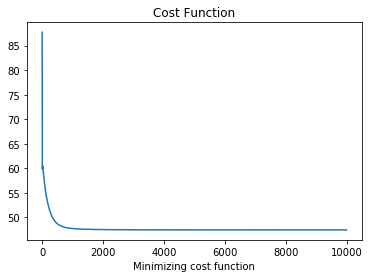

In [513]:
plt.plot(J_Array) 
  
# naming the x axis 
plt.xlabel('Minimizing cost function') 
plt.title('Cost Function') 
# function to show the plot 
plt.show()

In [514]:
y_pred_grad=lr.predict(X_test,Y_test)
output_df = pd.DataFrame(columns = ['Actual', 'Predicted'])
y_pred_grad = pd.Series(y_pred_grad)
output_df["Predicted"] = y_pred_grad
output_df.loc[output_df.Predicted < 0 , 'Predicted'] = 0
Y_test1= Y_test.reset_index()
Y_test1= Y_test1.drop("index", axis =1)
output_df["Actual"] =  Y_test1
output_df["SquaredDifference"] = np.square(output_df["Predicted"] - output_df["Actual"])
output_df.head()

,Actual,Predicted,SquaredDifference
0,201,315.463247,13101.834942
1,304,230.276066,5435.218468
2,10,85.494438,5699.410183
3,288,245.024365,1846.905208
4,49,70.112784,445.749646


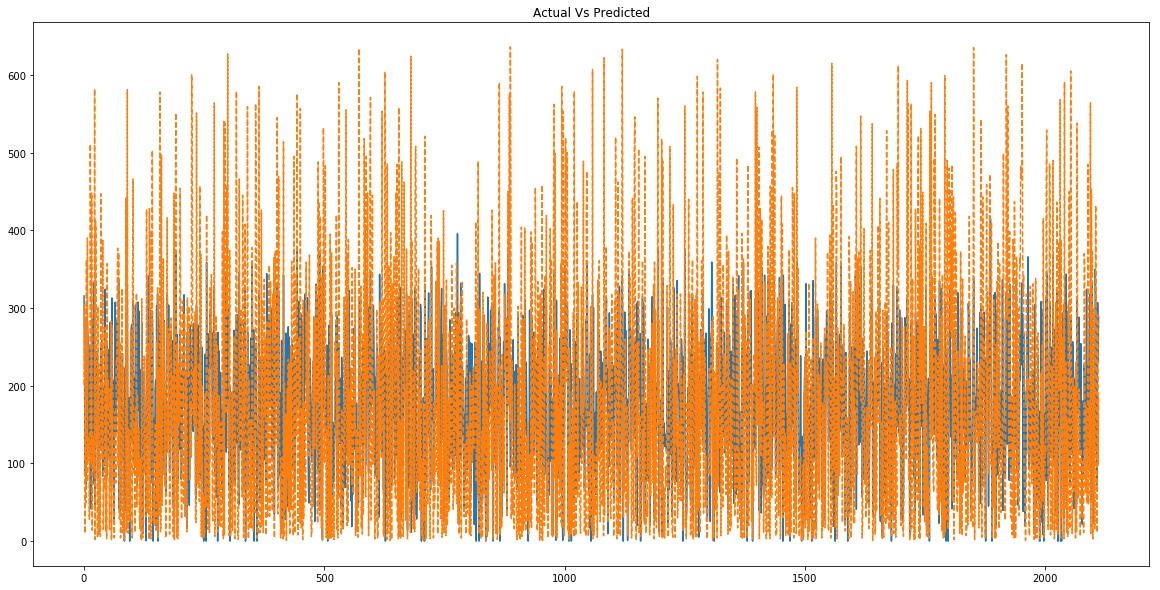

In [515]:
# Y_test= Y_test.reset_index()
# Y_test= Y_test.drop("index", axis =1)
# Y_test= Y_test.drop("level_0", axis =1)
plt.figure(figsize=(20,10))
plt.plot(output_df.Predicted)
plt.plot(output_df.Actual, '--')
plt.title("Actual Vs Predicted")
plt.show()

In [405]:
y_pred_grad,ErrorPercentage=lr.predictUsingNormalEquation(X_test,Y_test)
print(ErrorPercentage.mean())

324.1332573403551
